# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.


План:    

1 Загрузим и обработаем данные.

2 Подберем несколько моделей.
    
3 После анализа выберем модель которая лучше всего подойдет заказчику.


## Подготовка данных

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

In [81]:
try:
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [83]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<div class="alert alert-info" role="alert">
Устраним дубликаты и пропуски.
</div>

<div class="alert alert-info" role="alert">
Уберем стобцы с датой,кодом(неинформативны для обучения) и модели авто(слишком много категорий)
</div>

In [84]:
df = df.drop(columns = ['DateCrawled','Model','RegistrationMonth','DateCreated','LastSeen','PostalCode'],axis=1)


In [85]:
df.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Kilometer               0
FuelType            32895
Brand                   0
NotRepaired         71154
NumberOfPictures        0
dtype: int64

<div class="alert alert-info" role="alert">
 Заполним пропуски заглушками
</div>

In [86]:
df=df.fillna('plug')

In [87]:
df['Price'] = pd.to_numeric(df['Price'])
df['NumberOfPictures'] = pd.to_numeric(df['NumberOfPictures'])
df['RegistrationYear'] = pd.to_numeric(df['RegistrationYear'])
df['Power'] = pd.to_numeric(df['Power'])
df['Kilometer'] = pd.to_numeric(df['Kilometer'])

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       354369 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           354369 non-null  object
 4   Power             354369 non-null  int64 
 5   Kilometer         354369 non-null  int64 
 6   FuelType          354369 non-null  object
 7   Brand             354369 non-null  object
 8   NotRepaired       354369 non-null  object
 9   NumberOfPictures  354369 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 27.0+ MB


In [89]:
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired', 'NumberOfPictures'],
      dtype='object')

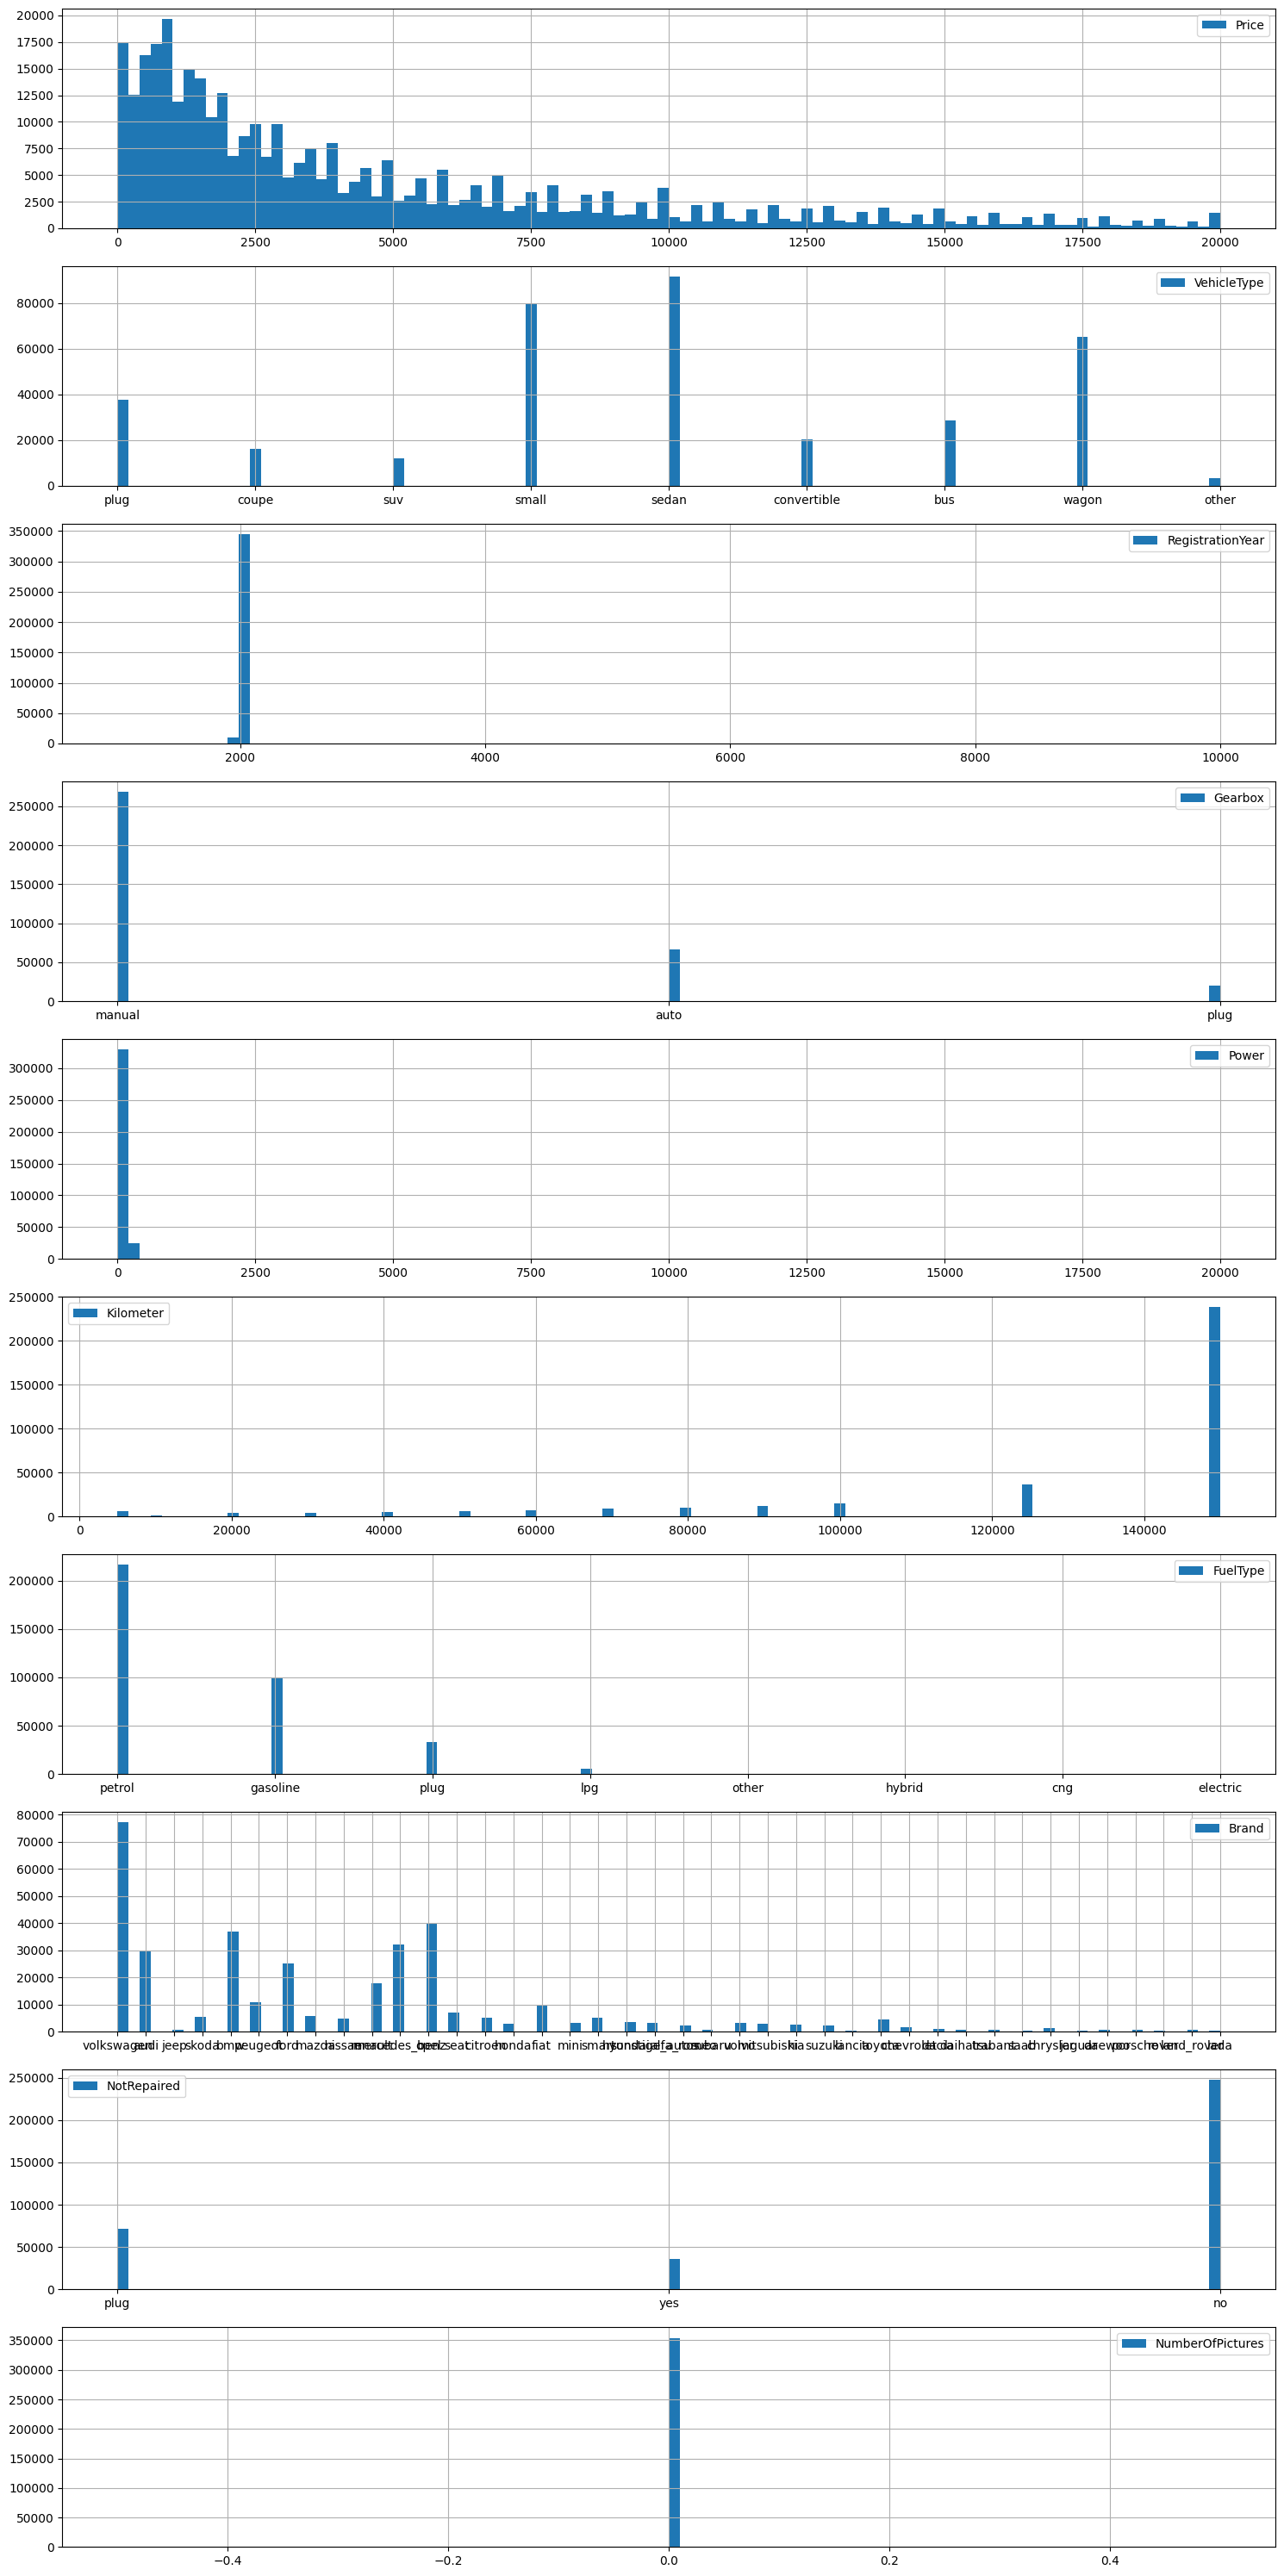

In [95]:
fig = plt.figure()
total_axes = len(df.columns) 
subplt = 1 
for x in df.columns:
    ax = fig.add_subplot(total_axes, 1, subplt) 
    df[x].hist(figsize=(15,30),bins=100,legend=1) 
    subplt+=1
    

plt.tight_layout()
plt.show()

In [59]:
try:
    q = pd.read_csv('autos.csv')
except:
    q = pd.read_csv('/datasets/autos.csv')
q['DateCrawled'].max()

'2016-04-07 14:36:58'

<div class="alert alert-info" role="alert">
По гистограмам может отделить аномалии:
        
Регистрация авто(Даже если брать популярные ретро-авто это от 1950 годов,начало активного производства авто как таковых было ближе к 1900) возьмем ранний срок 1900 и ограницим последней датой DateCrawled 2016.
    
Мощность авто,возьмем от 20 (Авто должно хотя бы тронутся с места) и ограничим 4600 (Почему бы не продавать Белаз )
    
Цену ограничим от 1 евро
    
Количество фото везде 0 (стоило бы сообщить о таком в соответствующий отдел) столбец не информативен
</div>

In [60]:
df = df.query('2016 > RegistrationYear > 1900')
df = df.query('4600 > Power > 20')
df = df.drop(columns='NumberOfPictures')
df = df.query('1 < Price')

<div class="alert alert-info" role="alert">
 Кодируем данные техникой OHE и сохраним отдельно некодированый датасет для модели CatBoost
</div>

In [61]:
df.duplicated().sum()

43853

In [62]:
df = df.drop_duplicates()

In [63]:
df_cat = df.copy()
list_ohe = ['VehicleType','Gearbox','FuelType','NotRepaired','Brand']

In [64]:
for_df_ohe = pd.get_dummies(df[list_ohe])

In [65]:
df = df.drop(columns=list_ohe,axis = 1)

In [66]:
df_ohe = df.join(for_df_ohe)

In [67]:
df_ohe

,Price,RegistrationYear,Power,Kilometer,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_plug,VehicleType_sedan,...,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo
1,18300,2011,190,125000,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9800,2004,163,125000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1500,2001,75,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,3600,2008,69,90000,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,650,1995,102,150000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354357,1690,2004,55,150000,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
354362,3200,2004,225,150000,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
354366,1199,2000,101,125000,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
354367,9200,1996,102,150000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## Обучение моделей

<div class="alert alert-info" role="alert">
Обучим модель LGBMRegressor
</div>

In [68]:
X = df_ohe.drop('Price',axis=1)
y = df['Price']

In [69]:
X_train,X_test_q,y_train,y_test_q = train_test_split(X,y,random_state = 42,test_size = .4)
X_test,X_main,y_test,y_main = train_test_split(X_test_q,y_test_q,random_state = 42,test_size = .5)

In [70]:
%%time
model = lgb.LGBMRegressor(objective='regression',num_leaves=51,learning_rate=.1,n_estimators=30)
model.fit(X_train, y_train,eval_set=[(X_test, y_test)],eval_metric='l1')

[1]	valid_0's l1: 3448.36	valid_0's l2: 1.89332e+07
[2]	valid_0's l1: 3186.76	valid_0's l2: 1.63155e+07
[3]	valid_0's l1: 2956.19	valid_0's l2: 1.41853e+07
[4]	valid_0's l1: 2752.48	valid_0's l2: 1.24423e+07
[5]	valid_0's l1: 2569.79	valid_0's l2: 1.09932e+07
[6]	valid_0's l1: 2411.86	valid_0's l2: 9.81075e+06
[7]	valid_0's l1: 2271.99	valid_0's l2: 8.83358e+06
[8]	valid_0's l1: 2147.85	valid_0's l2: 8.01351e+06
[9]	valid_0's l1: 2038.42	valid_0's l2: 7.32884e+06
[10]	valid_0's l1: 1944.96	valid_0's l2: 6.76853e+06
[11]	valid_0's l1: 1860.29	valid_0's l2: 6.28288e+06
[12]	valid_0's l1: 1782.86	valid_0's l2: 5.8623e+06
[13]	valid_0's l1: 1714.62	valid_0's l2: 5.51181e+06
[14]	valid_0's l1: 1655.85	valid_0's l2: 5.21487e+06
[15]	valid_0's l1: 1601.58	valid_0's l2: 4.9574e+06
[16]	valid_0's l1: 1554.71	valid_0's l2: 4.7329e+06
[17]	valid_0's l1: 1511.2	valid_0's l2: 4.54096e+06
[18]	valid_0's l1: 1473.87	valid_0's l2: 4.37472e+06
[19]	valid_0's l1: 1441.25	valid_0's l2: 4.22965e+06
[20]	v

LGBMRegressor(n_estimators=30, num_leaves=51, objective='regression')

In [71]:
%%time
pred = model.predict(X_test,num_iteration=model.best_iteration_)
rmse_lgb = mean_squared_error(y_test,pred) ** .5

CPU times: total: 328 ms
Wall time: 44.9 ms


<div class="alert alert-info" role="alert">
Обучим обычную модель линейной регрессии
</div>

In [72]:
%%time
reg_model = LinearRegression()
reg_model.fit(X_train,y_train)

CPU times: total: 4.8 s
Wall time: 823 ms


LinearRegression()

In [73]:
%%time
reg_pred = reg_model.predict(X_test)
rmse_lr = mean_squared_error(y_test,reg_pred) **.5

CPU times: total: 15.6 ms
Wall time: 21.9 ms


<div class="alert alert-info" role="alert">
И обучим модель CatBoostRegressor
</div>

In [74]:
cat_X = df_cat.drop('Price',axis=1)
cat_y = df_cat['Price']
cat_X_train,cat_X_test1,cat_y_train,cat_y_test1 = train_test_split(cat_X,cat_y,random_state=42,test_size= .4)
cat_X_test,cat_X_main,cat_y_test,cat_y_main = train_test_split(cat_X_test1,cat_y_test1,random_state=42,test_size= .5)
cat_features = ['VehicleType','RegistrationYear','Gearbox','FuelType','NotRepaired','Brand']

In [75]:
%%time
cat_model = CatBoostRegressor(loss_function="RMSE",iterations=200)
cat_model.fit(cat_X_train, cat_y_train, cat_features=cat_features, verbose=10)

Learning rate set to 0.333459
0:	learn: 3682.0793237	total: 73.7ms	remaining: 14.7s
10:	learn: 1908.6851986	total: 785ms	remaining: 13.5s
20:	learn: 1821.4141414	total: 1.45s	remaining: 12.4s
30:	learn: 1779.6478231	total: 2.15s	remaining: 11.7s
40:	learn: 1751.5392315	total: 2.88s	remaining: 11.2s
50:	learn: 1733.0407030	total: 3.63s	remaining: 10.6s
60:	learn: 1713.6945574	total: 4.43s	remaining: 10.1s
70:	learn: 1703.8204815	total: 5.18s	remaining: 9.4s
80:	learn: 1692.8045526	total: 5.97s	remaining: 8.77s
90:	learn: 1685.3965767	total: 6.78s	remaining: 8.13s
100:	learn: 1676.6534220	total: 7.51s	remaining: 7.36s
110:	learn: 1669.1432248	total: 8.18s	remaining: 6.56s
120:	learn: 1665.5128553	total: 8.9s	remaining: 5.81s
130:	learn: 1658.3661452	total: 9.7s	remaining: 5.11s
140:	learn: 1651.3059409	total: 10.5s	remaining: 4.39s
150:	learn: 1644.9221192	total: 11.2s	remaining: 3.64s
160:	learn: 1640.5021152	total: 12s	remaining: 2.9s
170:	learn: 1636.2116812	total: 12.7s	remaining: 2.

In [76]:
%%time
cat_pred = cat_model.predict(cat_X_test)
rmse_cat = mean_squared_error(cat_y_test,cat_pred) ** .5

CPU times: total: 188 ms
Wall time: 85.8 ms


## Анализ моделей

<div class="alert alert-info" role="alert">
Подведем результаты
</div>

In [77]:
pd.DataFrame([['LGBMRegressor',rmse_lgb],['LinearRegression',rmse_lr],['CatBoostRegressor',rmse_cat]],columns=['model','RMSE'])

,model,RMSE
0,LGBMRegressor,1850.736514
1,LinearRegression,2920.322322
2,CatBoostRegressor,1687.959037


In [78]:
%%time
pred = model.predict(X_main,num_iteration=model.best_iteration_)
rmse_lgb_main = mean_squared_error(y_main,pred) ** .5
print('RMSE модели LGBMRegressor на финальном тесте:', rmse_lgb_main)

RMSE модели LGBMRegressor на финальном тесте: 1867.0423648406152
CPU times: total: 266 ms
Wall time: 39.9 ms


## Вывод

<div class="alert alert-info" role="alert">
Для лучшего результата лучше всего подойдет модель CatBoost.
    
Вполне можно использовать модель LGB которая показывает не на много худший чем CatBoost  и вполне подходящий под наше условие RMSE менее 2500.Время обучения модели многократно быстрее чем на CatBoost и время предсказания быстрее в ~2 раза.
    
Рекомендованная модель:    LGBMRegressor
</div>